<a href="https://colab.research.google.com/github/sonenhur/k5_pytorch/blob/main/quickstart_tutorial_2024_02_02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
# @title
!pip install matplotlib

In [19]:
# For tips on running notebooks in Google Colab, see
# https://pytorch.org/tutorials/beginner/colab
%matplotlib inline


[Learn the Basics](intro.html) ||
**Quickstart** ||
[Tensors](tensorqs_tutorial.html) ||
[Datasets & DataLoaders](data_tutorial.html) ||
[Transforms](transforms_tutorial.html) ||
[Build Model](buildmodel_tutorial.html) ||
[Autograd](autogradqs_tutorial.html) ||
[Optimization](optimization_tutorial.html) ||
[Save & Load Model](saveloadrun_tutorial.html)

# Quickstart
This section runs through the API for common tasks in machine learning. Refer to the links in each section to dive deeper.

## Working with data
PyTorch has two [primitives to work with data](https://pytorch.org/docs/stable/data.html):
``torch.utils.data.DataLoader`` and ``torch.utils.data.Dataset``.
``Dataset`` stores the samples and their corresponding labels, and ``DataLoader`` wraps an iterable around
the ``Dataset``.


In [20]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

PyTorch offers domain-specific libraries such as [TorchText](https://pytorch.org/text/stable/index.html),
[TorchVision](https://pytorch.org/vision/stable/index.html), and [TorchAudio](https://pytorch.org/audio/stable/index.html),
all of which include datasets. For this tutorial, we  will be using a TorchVision dataset.

The ``torchvision.datasets`` module contains ``Dataset`` objects for many real-world vision data like
CIFAR, COCO ([full list here](https://pytorch.org/vision/stable/datasets.html)). In this tutorial, we
use the FashionMNIST dataset. Every TorchVision ``Dataset`` includes two arguments: ``transform`` and
``target_transform`` to modify the samples and labels respectively.



In [21]:
import os
import shutil
from pathlib import Path

from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, ToPILImage

We pass the ``Dataset`` as an argument to ``DataLoader``. This wraps an iterable over our dataset, and supports
automatic batching, sampling, shuffling and multiprocess data loading. Here we define a batch size of 64, i.e. each element
in the dataloader iterable will return a batch of 64 features and labels.



In [22]:
import torchvision

In [23]:
# # 공개 데이터셋에서 학습 데이터를 내려받습니다.
# training_data = datasets.MNIST(
#     root="data",
#     train=True,
#     download=True,
#     transform=ToTensor(),
# )

# # 공개 데이터셋에서 테스트 데이터를 내려받습니다.
# test_data = datasets.MNIST(
#     root="data",
#     train=False,
#     download=True,
#     transform=ToTensor(),
# )
import torchvision
from torchvision import transforms

train_transform = transforms.Compose(
                [
                    transforms.Resize([256, 256]),
                    transforms.RandomResizedCrop(224),
                    transforms.RandomHorizontalFlip(),
                    transforms.ToTensor(),
                    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                ])

test_transform = transforms.Compose(
                [
                    transforms.Resize([256, 256]),
                    transforms.CenterCrop(224),
                    #transforms.RandomHorizontalFlip(),
                    transforms.ToTensor(),
                    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                ])

# data_path = 'catanddog/train/'
# training_data = torchvision.datasets.ImageFolder(
#     data_path,
#     transform=train_transform
# )

# data_path = 'catanddog/test/'
# test_data = torchvision.datasets.ImageFolder(
#     data_path,
#     transform=test_transform
# )


In [24]:
import os
from pathlib import Path


# catanddog\train\Cat
# catanddog\train\Dog

def read_image(path):
  images = []
  labels = []
  for dir in os.listdir(path):
    image_dir = Path(path, dir)
    for f in os.listdir(image_dir):
      images.append(str(Path(image_dir, f)))
      labels.append(str(image_dir).split(os.sep)[-1])
  return images, labels

path = Path('/data/catanddog', 'train/')
images, labels = read_image(path)
print(len(images), images[0], len(labels), labels[0])



path = Path('/data/dogs-vs-cats')
images, labels = read_image(path)
print(len(images), len(labels))

385 \data\catanddog\train\Cat\0.jpg 385 Cat
502 502


In [25]:
import os
from pathlib import Path

# dogs-vs-cats\Cat
# dogs-vs-cats\Dog

path = Path('/data/dogs-vs-cats')

for dir in os.listdir(path):
  image_dir = Path(path, dir)
  for f in os.listdir(image_dir):
    print(Path(image_dir, f))
    print(str(image_dir).split(os.sep)[-1])
    break

\data\dogs-vs-cats\Cat\cat.0.jpg
Cat
\data\dogs-vs-cats\Dog\dog.0.jpg
Dog


In [26]:
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1mRIxd83kR3F6fBSozYaYSlqrN8hSxfIc' -O dogs-vs-cats.zip

'wget'은(는) 내부 또는 외부 명령, 실행할 수 있는 프로그램, 또는
배치 파일이 아닙니다.
'id'은(는) 내부 또는 외부 명령, 실행할 수 있는 프로그램, 또는
배치 파일이 아닙니다.


In [27]:
!unzip dogs-vs-cats.zip -d dogs-vs-cats

'unzip'은(는) 내부 또는 외부 명령, 실행할 수 있는 프로그램, 또는
배치 파일이 아닙니다.


In [28]:
from PIL import Image
from torch.utils.data import Dataset

class CatandDogDataset(Dataset):
  classes = {
      'Cat': 0,
      'Dog': 1,
      }

  def __init__(self, file_path, transform=None):
    self.file_path = file_path
    self.transform = transform
    self.images, self.labels = self.__read_images()

  def __read_images(self):
    images = []
    labels = []
    for dir in os.listdir(self.file_path):
      image_dir = Path(self.file_path, dir)
      for f in os.listdir(image_dir):
        images.append(str(Path(image_dir, f)))
        labels.append(str(image_dir).split(os.sep)[-1])
    return images, labels

  def __len__(self):
    return len(self.images)

  def __getitem__(self, idx):
    image_path = self.images[idx]
    label = self.classes[self.labels[idx]]
    #print(type(image_path), image_path)
    #print(type(label), label)
    img = Image.open(image_path)
    img = self.transform(img)

    return img, label

In [29]:
path = Path('/data/dogs-vs-cats')
len(CatandDogDataset(path, transform=train_transform))

502

In [30]:
import torch
from torch.utils.data import random_split

path = Path('/data/dogs-vs-cats')
dataset = CatandDogDataset(path, transform=train_transform)

In [31]:
img, label = dataset.__getitem__(0)
img.shape, label

(torch.Size([3, 224, 224]), 0)

In [32]:
#training_data = CatandDogDataset(data_path, transform=train_transform)[:300]
#test_data = CatandDogDataset(data_path, transform=train_transform)[300:]
train_test_ratio = 0.8
n_train = int(len(dataset) * train_test_ratio)
n_test = len(dataset) - n_train
training_data, test_data = torch.utils.data.random_split(dataset, [n_train, n_test])
test_data.transform = test_transform
len(training_data), len(test_data)

(401, 101)

In [33]:
batch_size = 32

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

for X, y in train_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}, type: {X.dtype}, {type(X)}")
    print(f"Shape of y: {y}, {y.shape} {y.dtype}")
    break

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}, type: {X.dtype}, {type(X)}")
    print(f"Shape of y: {y}, {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([32, 3, 224, 224]), type: torch.float32, <class 'torch.Tensor'>
Shape of y: tensor([1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0,
        1, 1, 0, 0, 1, 1, 1, 1]), torch.Size([32]) torch.int64
Shape of X [N, C, H, W]: torch.Size([32, 3, 224, 224]), type: torch.float32, <class 'torch.Tensor'>
Shape of y: tensor([0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1,
        0, 0, 1, 1, 1, 1, 1, 0]), torch.Size([32]) torch.int64


Read more about [loading data in PyTorch](data_tutorial.html).




--------------




## Creating Models
To define a neural network in PyTorch, we create a class that inherits
from [nn.Module](https://pytorch.org/docs/stable/generated/torch.nn.Module.html). We define the layers of the network
in the ``__init__`` function and specify how data will pass through the network in the ``forward`` function. To accelerate
operations in the neural network, we move it to the GPU or MPS if available.



In [34]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

import torch
from torch import nn


class LeNet(nn.Module):
  def __init__(self):
    super(LeNet, self).__init__()
    self.features = nn.Sequential(
        nn.Conv2d(3, 6, 5, padding='same'),
        nn.BatchNorm2d(6),
        nn.ReLU(),
        nn.MaxPool2d(2),
        nn.Conv2d(6, 16, 5, padding='same'),
        nn.ReLU(),
        nn.MaxPool2d(2),
        #nn.Conv2d(16, 120, 7),
        #nn.ReLU(),
    )
    #self.maxpool = nn.MaxPool2d(7)
    self.classifier = nn.Sequential(
        nn.Dropout(p=0.5),
        nn.Flatten(),
        nn.Linear(16*56*56, 256),
        nn.ReLU(),
        nn.Dropout(p=0.5),
        nn.Linear(256, 64),
        nn.ReLU(),
        nn.Dropout(p=0.5),
        #nn.Sigmoid(),
        nn.Linear(64, 2),
        #nn.Softmax(dim=1)
    )

  def forward(self, x):
    features = self.features(x)
    #print(features.shape)
    #features = self.maxpool(features)
    #print(features.shape)
    out = self.classifier(features)
    #print(out.shape)
    return out


Using cuda device


In [35]:
input = torch.randn(32, 3, 224, 224).to(device)
model = LeNet().to(device)
output = model(input)
type(output), len(output), output.shape

(torch.Tensor, 32, torch.Size([32, 2]))

In [36]:
model

LeNet(
  (features): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1), padding=same)
    (1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1), padding=same)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Flatten(start_dim=1, end_dim=-1)
    (2): Linear(in_features=50176, out_features=256, bias=True)
    (3): ReLU()
    (4): Dropout(p=0.5, inplace=False)
    (5): Linear(in_features=256, out_features=64, bias=True)
    (6): ReLU()
    (7): Dropout(p=0.5, inplace=False)
    (8): Linear(in_features=64, out_features=2, bias=True)
  )
)

In [37]:
# from torchvision.models import list_models
# #torchvision.models.list_models()
# list_models()

In [38]:
from torchvision import models
from torchvision.models import resnet18, ResNet18_Weights

model_ft = models.resnet50(weights='IMAGENET1K_V1')

for param in model_ft.parameters():
    param.requires_grad = False

classfier = nn.Sequential(
  nn.Linear(2048, 256),
  nn.Dropout(),
  nn.ReLU(),
  nn.Linear(256, 64),
  nn.Dropout(),
  nn.ReLU(),
  nn.Linear(64, 2),
  nn.Softmax(dim=1)
)

model_ft.fc = classfier
model = model_ft.to(device)

In [39]:
input = torch.randn(32, 3, 224, 224).to(device)
output = model(input)
type(output), len(output), output.shape

(torch.Tensor, 32, torch.Size([32, 2]))

In [40]:
# !pip install torchinfo

In [41]:
# from torchinfo import summary

# def summary_model(model):
#   print(summary(model=model, input_size=(32, 3, 224, 224), col_width=20,
#                     col_names=['input_size', 'output_size', 'num_params', 'trainable'], row_settings=['var_names'], verbose=0))


# summary_model(model)

Read more about [building neural networks in PyTorch](buildmodel_tutorial.html).




In [42]:
# input = torch.randn(64, 1, 28, 28).to(device)
# output = model(input)
# output.dtype, output.shape

--------------




## Optimizing the Model Parameters
To train a model, we need a [loss function](https://pytorch.org/docs/stable/nn.html#loss-functions)
and an [optimizer](https://pytorch.org/docs/stable/optim.html).



https://miro.medium.com/v2/resize:fit:1400/format:webp/1*qe6nYlH8zsmUdScyHMhRCQ.png

In [43]:
from torch.optim.lr_scheduler import StepLR

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = StepLR(optimizer, step_size=3, gamma=0.1)

In a single training loop, the model makes predictions on the training dataset (fed to it in batches), and
backpropagates the prediction error to adjust the model's parameters.



In [44]:
def train(dataloader, model, loss_fn, optimizer):
  size = len(dataloader.dataset)
  model.train()
  for batch, (X, y) in enumerate(dataloader):
    X, y = X.to(device), y.to(device)

    # Compute prediction error
    pred = model(X)
    loss = loss_fn(pred, y)
    print(f'X: {X.dtype},{type(X)}, {X.shape}')
    #print(f'y: {y.dtype},{type(y)}, {y.shape}')
    #print(f'pred: {pred.dtype},{type(pred)}, {pred.shape}')
    #print(f'loss: {loss.dtype},{type(loss)}, {loss.shape}')

    # Backpropagation
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    #if batch % 100 == 0:
    loss, current = loss.item(), (batch + 1) * len(X)
    print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

We also check the model's performance against the test dataset to ensure it is learning.



In [45]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

The training process is conducted over several iterations (*epochs*). During each epoch, the model learns
parameters to make better predictions. We print the model's accuracy and loss at each epoch; we'd like to see the
accuracy increase and the loss decrease with every epoch.



In [46]:
epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    #test(test_dataloader, model, loss_fn)
    scheduler.step()
print("Done!")

Epoch 1
-------------------------------
X: torch.float32,<class 'torch.Tensor'>, torch.Size([32, 3, 224, 224])
loss: 0.685549  [   32/  401]
X: torch.float32,<class 'torch.Tensor'>, torch.Size([32, 3, 224, 224])
loss: 0.713092  [   64/  401]
X: torch.float32,<class 'torch.Tensor'>, torch.Size([32, 3, 224, 224])
loss: 0.672678  [   96/  401]
X: torch.float32,<class 'torch.Tensor'>, torch.Size([32, 3, 224, 224])
loss: 0.667352  [  128/  401]
X: torch.float32,<class 'torch.Tensor'>, torch.Size([32, 3, 224, 224])
loss: 0.727280  [  160/  401]
X: torch.float32,<class 'torch.Tensor'>, torch.Size([32, 3, 224, 224])
loss: 0.720412  [  192/  401]
X: torch.float32,<class 'torch.Tensor'>, torch.Size([32, 3, 224, 224])
loss: 0.675074  [  224/  401]
X: torch.float32,<class 'torch.Tensor'>, torch.Size([32, 3, 224, 224])
loss: 0.616828  [  256/  401]
X: torch.float32,<class 'torch.Tensor'>, torch.Size([32, 3, 224, 224])
loss: 0.634735  [  288/  401]
X: torch.float32,<class 'torch.Tensor'>, torch.Size

Read more about [Training your model](optimization_tutorial.html).




In [47]:
test(test_dataloader, model, loss_fn)

Test Error: 
 Accuracy: 95.0%, Avg loss: 0.383527 



--------------




## Saving Models
A common way to save a model is to serialize the internal state dictionary (containing the model parameters).



In [48]:
torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


## Loading Models

The process for loading a model includes re-creating the model structure and loading
the state dictionary into it.



In [49]:
# model = LeNet().to(device)
# model.load_state_dict(torch.load("model.pth"))
# model

This model can now be used to make predictions.



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 224, 224]) 1
<built-in method size of Tensor object at 0x0000027AA8C02490>
Predicted: "Dog", Actual: "Dog"


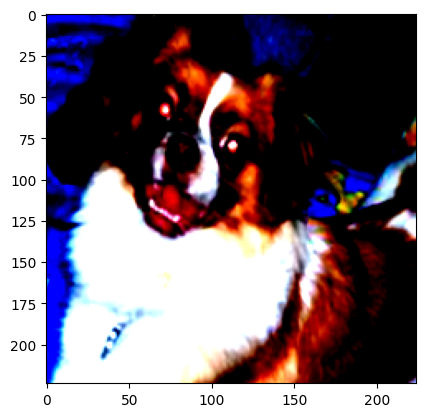

In [50]:
import matplotlib.pyplot as plt

# classes = [
#     "T-shirt/top",
#     "Trouser",
#     "Pullover",
#     "Dress",
#     "Coat",
#     "Sandal",
#     "Shirt",
#     "Sneaker",
#     "Bag",
#     "Ankle boot",
# ]

classes = [
    "Cat",
    "Dog",
]

model.eval()
x, y = test_data[0][0], test_data[0][1]
print(x.shape, y)
x = x.expand(1, 3, 224, 224)
with torch.no_grad():
  x = x.to(device)
  pred = model(x)
  predicted, actual = classes[pred[0].argmax(0)], classes[y]
  x_img = x.squeeze().permute(1, 2, 0).cpu()
  print(x_img.size)
  plt.imshow(x_img)
  print(f'Predicted: "{predicted}", Actual: "{actual}"')

Read more about [Saving & Loading your model](saveloadrun_tutorial.html).




In [51]:
!pip install lightning

     ---------------------------------------- 0.0/57.2 kB ? eta -:--:--
     -------------------- ----------------- 30.7/57.2 kB 435.7 kB/s eta 0:00:01
     -------------------------------------- 57.2/57.2 kB 601.5 kB/s eta 0:00:00
   ---------------------------------------- 0.0/2.0 MB ? eta -:--:--
   -------- ------------------------------- 0.4/2.0 MB 12.9 MB/s eta 0:00:01
   --------------- ------------------------ 0.8/2.0 MB 12.9 MB/s eta 0:00:01
   ------------------------- -------------- 1.3/2.0 MB 10.2 MB/s eta 0:00:01
   ---------------------------------- ----- 1.8/2.0 MB 11.3 MB/s eta 0:00:01
   ---------------------------------------- 2.0/2.0 MB 10.8 MB/s eta 0:00:00
   ---------------------------------------- 0.0/778.1 kB ? eta -:--:--
   ------------------------- ------------- 501.8/778.1 kB 15.4 MB/s eta 0:00:01
   --------------------------------------- 778.1/778.1 kB 12.2 MB/s eta 0:00:00
   ---------------------------------------- 0.0/363.4 kB ? eta -:--:--
   ---------

In [52]:
import torch
from torch import nn
from torch.optim import Adam
from torch.nn.functional import cross_entropy

from torchmetrics.classification import Accuracy

import lightning as L

# # A LightningModule (nn.Module subclass) defines a full *system*
class LitLeNet(L.LightningModule):
  def __init__(self):
    super().__init__()
    self.accuracy = Accuracy(task="multiclass", num_classes=2)
    self.features = nn.Sequential(
        nn.Conv2d(3, 6, 5, padding='same'),
        nn.BatchNorm2d(6),
        nn.ReLU(),
        nn.MaxPool2d(2),
        nn.Conv2d(6, 16, 5, padding='same'),
        nn.ReLU(),
        nn.MaxPool2d(2),
        #nn.Conv2d(16, 120, 7),
        #nn.ReLU(),
    )
    #self.maxpool = nn.MaxPool2d(7)
    self.classifier = nn.Sequential(
        nn.Dropout(p=0.5),
        nn.Flatten(),
        nn.Linear(16*56*56, 256),
        nn.ReLU(),
        nn.Dropout(p=0.5),
        nn.Linear(256, 64),
        nn.ReLU(),
        nn.Dropout(p=0.5),
        #nn.Sigmoid(),
        nn.Linear(64, 2),
        #nn.Softmax(dim=1)
    )

  def forward(self, x):
    features = self.features(x)
    #print(features.shape)
    #features = self.maxpool(features)
    #print(features.shape)
    out = self.classifier(features)
    #print(out.shape)
    return out

  def training_step(self, batch, batch_idx):
    X, y = batch
    #X, y = X.to(device), y.to(device)
    pred = self.forward(X)
    loss = cross_entropy(pred, y)
    self.log("train_loss", loss, prog_bar=True)
    accuracy = self.accuracy(pred, y)
    self.log('train_acc_step', accuracy, prog_bar=True)

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

  def on_train_epoch_end(self):
      self.log('train_acc_epoch', self.accuracy)

  def validation_step(self, batch, batch_idx):
    X, y = batch
    pred = self.forward(X)
    loss = cross_entropy(pred, y)
    self.log("val_loss", loss, prog_bar=True)
    accuracy = self.accuracy(pred, y)
    self.log('val_acc_step', accuracy, prog_bar=True)

  def configure_optimizers(self):
    optimizer = Adam(model.parameters(), lr=1e-3)
    return optimizer

In [53]:
from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint

model = LitLeNet()
trainer = L.Trainer(max_epochs=5)
es = EarlyStopping(monitor='val_loss')
checkpoint = ModelCheckpoint(monitor='val_loss', )
#trainer = L.Trainer(callbacks=[es, checkpoint], max_epochs=5, default_root_dir="models")
trainer.fit(model, train_dataloader, test_dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: C:\Dev\od_finetune\lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type               | Params
--------------------------------------------------
0 | accuracy   | MulticlassAccuracy | 0     
1 | features   | Sequential         | 2.9 K 
2 | classifier | Sequential         | 12.9 M
--------------------------------------------------
12.9 M    Trainable params
0         Non-trainable params
12.9 M    Total params
51.459    Total estimated model params size (MB)


Sanity Checking: |                                                                               | 0/? [00:00<…

C:\Users\user\anaconda3\envs\torch_book\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:492: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
C:\Users\user\anaconda3\envs\torch_book\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
C:\Users\user\anaconda3\envs\torch_book\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
C:\Users\user\anaconda3\envs\torch_book\Lib\site-packages\lightning\pytorch\loops\fit_loop.py:293: The number 

Training: |                                                                                      | 0/? [00:00<…

C:\Users\user\anaconda3\envs\torch_book\Lib\site-packages\lightning\pytorch\loops\optimization\automatic.py:129: `training_step` returned `None`. If this was on purpose, ignore this warning...


Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=5` reached.


In [54]:
!dir

 C 드라이브의 볼륨에는 이름이 없습니다.
 볼륨 일련 번호: CD26-C79F

 C:\Dev\od_finetune 디렉터리

2024-02-06  오후 05:29    <DIR>          .
2024-02-06  오후 05:29    <DIR>          ..
2024-02-06  오후 02:32    <DIR>          .ipynb_checkpoints
2024-02-06  오후 02:24    <DIR>          .virtual_documents
2024-02-06  오후 02:32         1,968,965 COCO dataset.ipynb
2024-02-06  오후 02:48             6,447 coco_eval.py
2024-02-06  오후 02:48             8,397 coco_utils.py
2024-02-06  오후 03:51    <DIR>          cvat
2024-02-06  오후 02:13    <DIR>          data
2024-02-06  오후 02:48             4,063 engine.py
2024-02-06  오후 04:51           993,169 License_Plate.ipynb
2024-02-06  오후 05:29    <DIR>          lightning_logs
2024-02-06  오후 05:29        96,497,690 model.pth
2024-02-06  오후 03:26         3,305,223 torchvision_tutorial.ipynb
2024-02-06  오후 02:48            23,628 transforms.py
2024-02-06  오후 02:48             8,388 utils.py
2024-02-06  오후 02:49    <DIR>          __pycache__
               9개 파일         102,815,970 바이트
    

```bash
$ docker run -it -p 8888:8888 -p 6006:6006 tensorflow/tensorflow:nightly-py3-jupyter
```

In [55]:
#%reload_ext tensorboard
#%tensorboard --logdir lightning_logs --port 6006

In [56]:
checkpoint.best_model_path

''

In [57]:
model = LitLeNet.load_from_checkpoint(checkpoint.best_model_path)
model.eval()
test(test_dataloader, model, loss_fn)

PermissionError: [Errno 13] Permission denied: 'C:/Dev/od_finetune'